In [21]:
from keras.preprocessing.image import ImageDataGenerator

train_data_path = "train"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_path, shuffle=True, target_size=(200, 200), batch_size=20, class_mode='binary')

validation_dir = r"validation"
validation_generator = test_datagen.flow_from_directory(validation_dir, shuffle=True, target_size=(200, 200),
                                                                    batch_size=20, class_mode='binary')

Found 3345 images belonging to 2 classes.
Found 498 images belonging to 2 classes.


In [19]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras import models
from keras import optimizers
#import datetime

model =  models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(loss='binary_crossentropy', optimizer= optimizers.RMSprop(lr=1e-4), metrics=['acc'])

#model.fit(X_train, y_train, epochs=10, batch_size=500)

history = model.fit_generator(train_generator,steps_per_epoch=100, epochs=25, validation_data=validation_generator,
                                     validation_steps=40) # , callbacks=[tensorboard_callback])

Epoch 1/25
100/100 [==============================] - 72s 721ms/step - loss: 0.3096 - acc: 0.8594 - val_loss: 0.0383 - val_acc: 0.9477
Epoch 2/25
100/100 [==============================] - 71s 711ms/step - loss: 0.1491 - acc: 0.9530 - val_loss: 0.1243 - val_acc: 0.9609
Epoch 3/25
100/100 [==============================] - 71s 707ms/step - loss: 0.1104 - acc: 0.9673 - val_loss: 0.0701 - val_acc: 0.9630
Epoch 4/25
100/100 [==============================] - 71s 706ms/step - loss: 0.1116 - acc: 0.9665 - val_loss: 0.0211 - val_acc: 0.9674
Epoch 5/25
100/100 [==============================] - 72s 720ms/step - loss: 0.0929 - acc: 0.9703 - val_loss: 0.1001 - val_acc: 0.9554
Epoch 6/25
100/100 [==============================] - 70s 704ms/step - loss: 0.0816 - acc: 0.9773 - val_loss: 0.0055 - val_acc: 0.9661
Epoch 7/25
100/100 [==============================] - 72s 716ms/step - loss: 0.0836 - acc: 0.9750 - val_loss: 0.0363 - val_acc: 0.9694
Epoch 8/25
100/100 [==============================] - 7

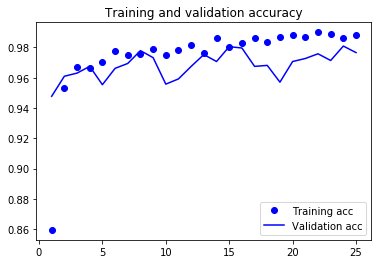

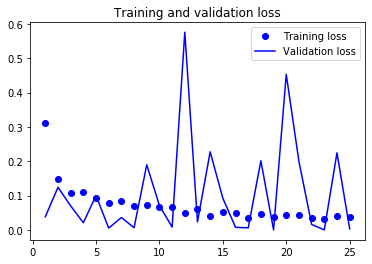

In [20]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [69]:
#results = model.evaluate(X_test, y_test)
#results
#history.history
print(model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 25, 25, 128)     

In [22]:
model.save('Mask_on_Face_small_12_1.h5')

In [23]:
# load the train model and test with live camera
import numpy as np
import cv2
from pathlib import Path
import os
from tensorflow.keras import models

new_model = models.load_model(r"Mask_on_Face_small_12_1.h5")

def mask_detection(roiimage_array):
    roiimage_array = roiimage_array.reshape((1,) + roiimage_array.shape)
    roiimage_array = roiimage_array.astype('float32') / 255
    conf = new_model.predict(roiimage_array)
    return conf
    
# Load pre-trained model:
net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000_fp16.caffemodel")

cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()
    color_img  = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Get dimensions of the input image (to be used later):
    (h, w) = color_img.shape[:2]
    
    # Create 4-dimensional blob from image:
    blob = cv2.dnn.blobFromImage(color_img, 1.0, (300, 300), [104., 117., 123.], False, False)

    # Set the blob as input and obtain the detections:
    net.setInput(blob)
    detections = net.forward()

    # Initialize the number of detected faces counter detected_faces:
    detected_faces = 0
            
    # Iterate over all detections:
    for i in range(0, detections.shape[2]):
       
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]
        if confidence < 0.40:
            continue
                
        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.6:
            # Increment the number of detected faces:
            detected_faces += 1
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            roi = color_img[(startY): endY, (startX): endX]
            roiimage = cv2.resize(roi, (200, 200))
            #cv2.imwrite("dddd.jpg", roiimage)
            mask_conf = mask_detection(roiimage)
            #print(mask_conf)
            
            text = ""
            rect_color = ()
            if(float(mask_conf) < 0.50):
                # Draw the detection and the confidence:
                text = "{:.3f}%".format(confidence * 100)
                text += " Mask"
                text_color = (255,0,0)
                rect_color = (0,255,0)
            else:
                text = "{:.3f}%".format(confidence * 100)
                text += " No Mask"
                rect_color = (0,0,255)
                text_color = (255,0,0)
                
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY), rect_color, 3)
            cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, text_color, 2)
            
            
    cv2.imshow('frame',frame)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [31]:
# load the train model and test with live camera with YOLO
